## Put it all Together
  
**Goal of this notebook:**
- Demonstrate an example of how all the techniques outlines in the previous notebooks work together to achieve superior results
    - Azure Text Analytics for Heath will be used to suplement the note with ICD9 specific terminology
    - GPT-4o mini will be used to extract only the information we want to simplify the ~3000 token MIMIC-III note
    - Fine-tuned models will be used to create a classifier for the Chapter and Block (sub-category) levels of the ICD9 tree
    - A heirarchical coding approach will leverage FT'd models to generalize 'up' the tree and GPT-4o to do the final classification 
  
**Requirements**
- Populated .env file (see [.env.sample](./.env.sample))
- We will use components from the previous 4 sections in this repo, those requirements will apply

**Azure Text Analytics for Health**  

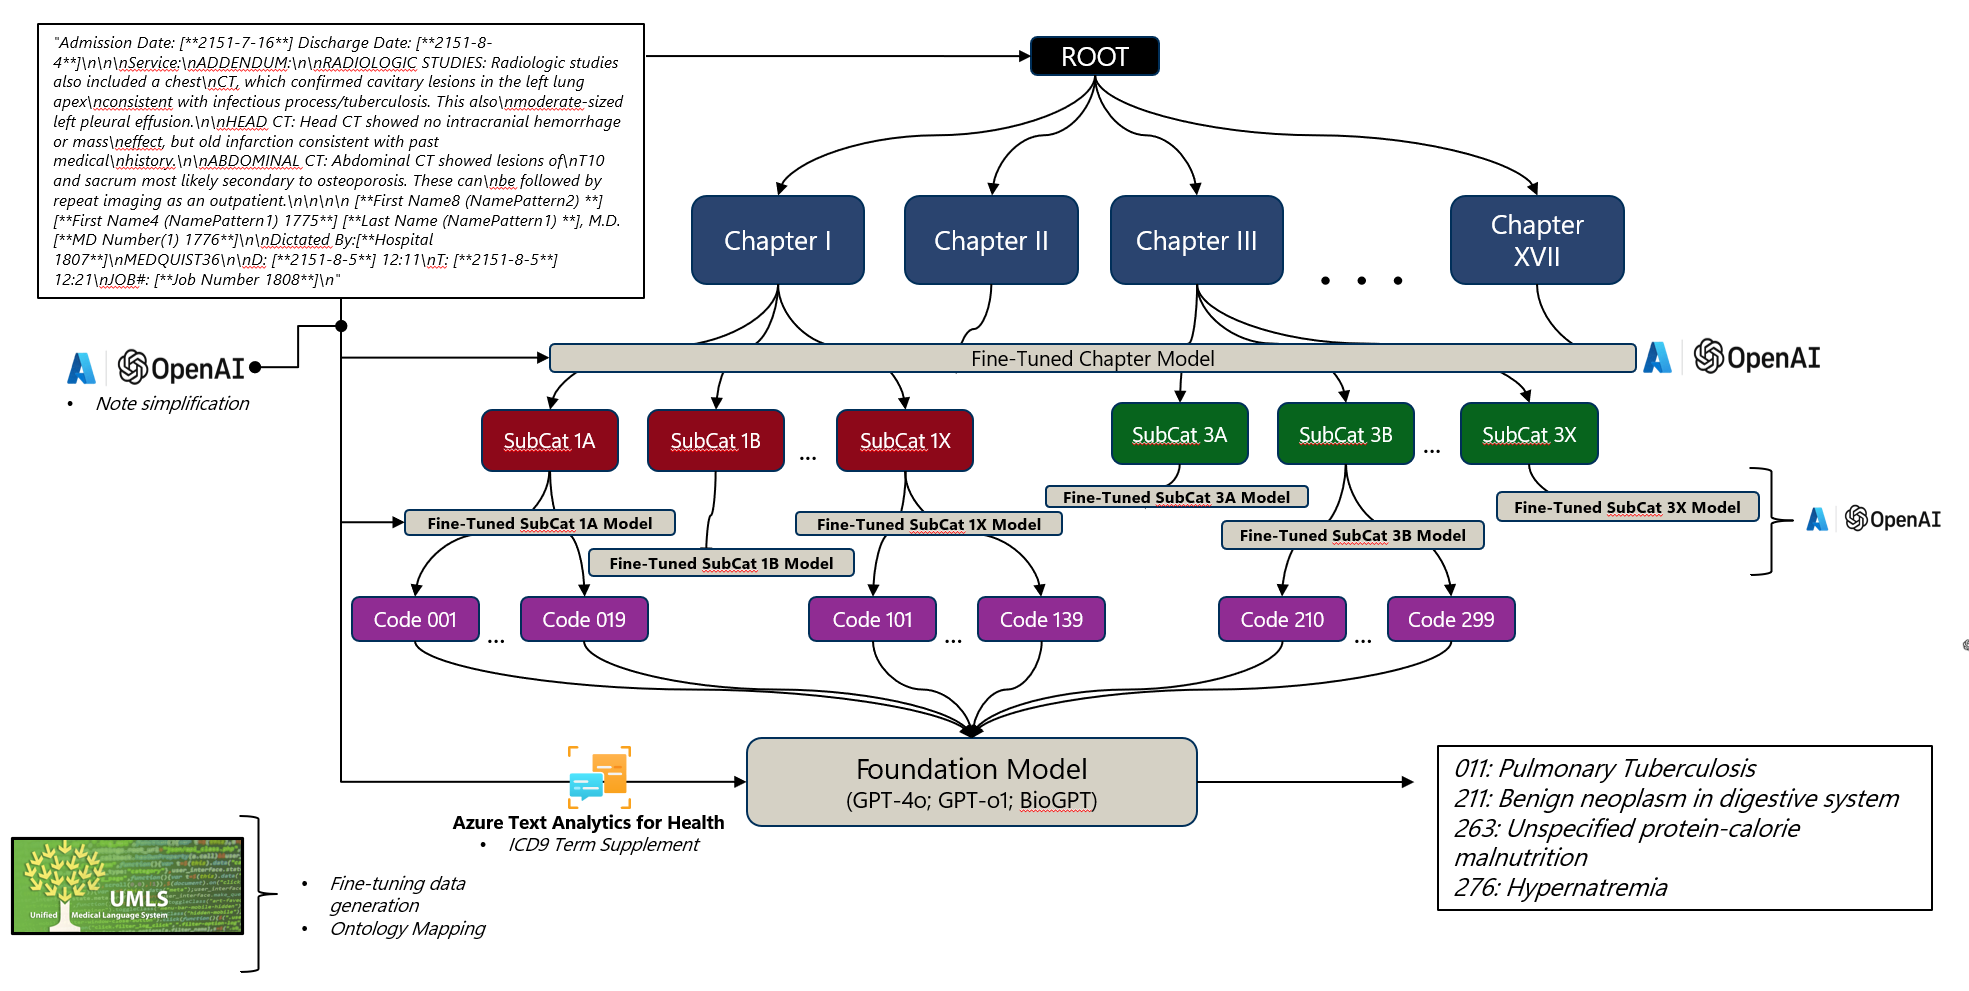

In [91]:
# import libraries
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential
from src.icd9_tree import ICD9
from dotenv import load_dotenv, find_dotenv
from openai import AzureOpenAI
from tqdm.notebook import tqdm
from textwrap import dedent
from nltk import flatten

import pandas as pd
import numpy as np
import ast
import random
import requests
import os
import re
import functools

load_dotenv(find_dotenv(), override=True)
pd.set_option('display.max_colwidth', None)

In [2]:
# setup clients and resources

key = os.getenv("LANGUAGE_KEY")
endpoint = os.getenv("LANGUAGE_ENDPOINT")

az_ta_client = TextAnalyticsClient(
        endpoint=endpoint, 
        credential=AzureKeyCredential(key))

# Establish client to Azure OpenAI
aoai_client = AzureOpenAI(
  azure_endpoint = os.getenv("AZURE_OPENAI_BASE"), 
  api_key=os.getenv("AZURE_OPENAI_KEY"),  
  api_version="2024-05-01-preview"
)

# Establish client to your fine-tuned model
finetuned_client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_BASE"), 
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-06-01"
)

---
#### Prepare Data

In [3]:
# Init code tree
tree = ICD9('icd9_codes_full.json')
toplevelnodes = tree.children
for node in toplevelnodes:
    if node.code[0] not in ['E', 'V']:
        print(node.code, node.description)

001-139 INFECTIOUS AND PARASITIC DISEASES 
140-239 NEOPLASMS 
240-279 ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS 
280-289 DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS 
290-319 MENTAL DISORDERS 
320-389 DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS 
390-459 DISEASES OF THE CIRCULATORY SYSTEM 
460-519 DISEASES OF THE RESPIRATORY SYSTEM 
520-579 DISEASES OF THE DIGESTIVE SYSTEM 
580-629 DISEASES OF THE GENITOURINARY SYSTEM 
630-679 COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM 
680-709 DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE 
710-739 DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE 
740-759 CONGENITAL ANOMALIES 
760-779 CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD 
780-799 SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS 
800-999 INJURY AND POISONING 


In [172]:
# Read in data
# Prepare eval data
mimic_df = pd.read_csv('data/joined/dataset_single_notes_full.csv.gz')
print(mimic_df.shape)
print(mimic_df.dtypes)

(21390, 5)
HADM_ID           int64
TEXT             object
ICD9_CODE        object
chapter_codes    object
subcat_codes     object
dtype: object


In [175]:
# Filter the data to subset of Chapters for demo purposes
# 390-459 DISEASES OF THE CIRCULATORY SYSTEM 
# 460-519 DISEASES OF THE RESPIRATORY SYSTEM 
# 520-579 DISEASES OF THE DIGESTIVE SYSTEM 

demo_df = mimic_df[mimic_df.chapter_codes.apply(lambda x: '390-459' in x or '460-519' in x or '520-579' in x)]

# Remove ICD9 codes not in those chapters
def filter_list(x):
    new_list = []
    x_list = ast.literal_eval(x)
    for code in x_list:
        try:
            if int(code) >= 390 and int(code) <= 579:
                new_list.append(code)
        except:
            pass

    return new_list


demo_df["ICD9_CODE"] = demo_df["ICD9_CODE"].apply(lambda x: filter_list(x))

print(demo_df.shape)

(17684, 5)


/tmp/ipykernel_1183/3996093492.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_df["ICD9_CODE"] = demo_df["ICD9_CODE"].apply(lambda x: filter_list(x))


In [176]:
# Take a sample to be used for evaluation
demo_df_sample = demo_df.sample(1, random_state=123)

In [177]:
# filter subcat codes

def filter_blocks(x, tree):
    new_list = []
    for block in ast.literal_eval(x):
        if tree.find(block).parents[1].code in ['390-459', '460-519', '520-579']:
            new_list.append(block)

    return new_list

demo_df_sample["subcat_codes"] = demo_df_sample["subcat_codes"].apply(lambda x: filter_blocks(x, tree))

In [178]:
# Filter chapter Codes

def filter_chapter_codes(x):
    new_list = []
    for chapter in ast.literal_eval(x):
        if chapter in ['390-459', '460-519', '520-579']:
            new_list.append(chapter)

    return new_list

demo_df_sample["chapter_codes"] = demo_df_sample["chapter_codes"].apply(lambda x: filter_chapter_codes(x))

In [179]:
# Clean TEXT
def clean_text(text):
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\n\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

tqdm.pandas()
demo_df_sample['TEXT'] = demo_df_sample['TEXT'].progress_apply(lambda x: clean_text(x))

  0%|          | 0/1 [00:00<?, ?it/s]

In [180]:
# Simplify MIMIC notes using GPT-4o-mini
tqdm.pandas()

# Funciton to build prompt
def build_prompt(note):
    sys = """
    Parse the following medical note and return sentances useful for ICD9 medical coding. Ignore other information such as patient name, dates, medicine types, dosage amounts, prior medical history, and prior treamtment.
    DO NOT ADD ANY INFORMATION TO THE NOTE. ONLY RETURN THE RELEVANT SENTENCES. 
    """
    prompt = f"{note}"

    return (sys, prompt)

def aoai_extract(note):
    sys, prompt = build_prompt(note)
    response = aoai_client.chat.completions.create(
        model=os.getenv("AOAI_MINI_DEPLOYMENT_NAME"), # model = "deployment_name".
        messages=[
            {"role": "system", "content": dedent(sys)},
            {"role": "user", "content": dedent(prompt)}
        ],
    )

    return response.choices[0].message.content

demo_df_sample["SIMPLE_TEXT"] = demo_df_sample["TEXT"].progress_apply(lambda x: aoai_extract(x))

  0%|          | 0/1 [00:00<?, ?it/s]

In [181]:
# Supplement MIMIC notes with ICD9 language from Azure Text Analytics for Health

def get_umls_atoms(cuid):
    synonyms = []
    sabs = ['ICD9CM']      
    atom_uri = f"https://uts-ws.nlm.nih.gov/rest/content/2024AA/CUI/{cuid}/atoms"
    page = 0  
    try:   
        while True:
            page += 1
            atom_query = {'apiKey':os.getenv("UMLS_API_KEY"), 'pageNumber':page, 'language':'ENG', 'sabs': ','.join(sabs)}
            a = requests.get(atom_uri, params=atom_query)
            a.encoding = 'utf-8'
            
            if a.status_code != 200:
                break

            all_atoms = a.json()
        
            for atom in all_atoms['result']:
                synonyms.append(re.sub("[\(\[].*?[\)\]]", "", atom['name']).lower().rstrip())
                #print(f'{atom}')

            return synonyms
            
    except Exception as except_error:
        print(except_error)
        return


# Get all UMLS concepts from the Azure Text Analytics API
def get_umls_concepts(client, documents):
    umls_concepts = []
    poller = client.begin_analyze_healthcare_entities(documents)
    result = poller.result()

    docs = [doc for doc in result if not doc.is_error]

    for idx, doc in enumerate(docs):
        for entity in doc.entities:
            if entity.data_sources and entity.category in ['SymptonOrSign', 'Diagnosis']:
                for data_source in entity.data_sources:
                    if data_source.name == "UMLS":
                        umls_concepts.append((data_source.entity_id, entity.text))

    return list(set(umls_concepts))

# Get UMLS definitions
def umls_define(cuid):    
    definitions = []
    umls_uri = f"https://uts-ws.nlm.nih.gov/rest/content/current/CUI/{cuid}/definitions"
    root_sources = ['CSP','NCI','MSH','PDQ', 'MTH', 'HPO', 'DXP', 'SNMI', 'SNOMEDCT_US', 'ICD10CM', 'ICD10', 'ICD9CM', 'MDR']  
    page = 0  
    try:   
        while True:
            page += 1
            query = {'apiKey':os.getenv("UMLS_API_KEY"), 'pageNumber':page}
            a = requests.get(umls_uri, params=query)
            a.encoding = 'utf-8'
            
            if a.status_code != 200:
                break
            result = a.json()
        
            for value in result['result']:
                if value['rootSource'] in root_sources:
                    definitions.append(value['value'].lower().rstrip())

            return list(set(definitions))
            
    except Exception as except_error:
        print(except_error)
        return

def supplement_note(note):
    umls_concepts = get_umls_concepts(az_ta_client, [note]) # output = (cuid, og_text)
    for concept in umls_concepts:
        atoms = get_umls_atoms(concept[0])
        if atoms:
            note = note.replace(concept[1].strip(), f"{concept[1]} ({', '.join(atoms)})")

    return note

# TEST
#note = demo_df_sample["SIMPLE_TEXT"].iloc[1]
#print(supplement_note(note))

In [182]:
# Supplement the notes
tqdm.pandas()
demo_df_sample["SIMPLE_TEXT"] = demo_df_sample["SIMPLE_TEXT"].progress_apply(lambda x: supplement_note(x))

  0%|          | 0/1 [00:00<?, ?it/s]

In [183]:
print(demo_df_sample.dtypes)
demo_df_sample[["TEXT","SIMPLE_TEXT","chapter_codes","subcat_codes", "ICD9_CODE"]].head(1)

HADM_ID           int64
TEXT             object
ICD9_CODE        object
chapter_codes    object
subcat_codes     object
SIMPLE_TEXT      object
dtype: object


TEXT  \
4143  ['Admission Date: [**2117-6-8**] Discharge Date: [**2117-6-15**]\n\nDate of Birth: [**2052-8-3**] Sex: M\n\nService: CARDIOTHORACIC\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 1505**]\nChief Complaint:\npositive exercise tolerance test\n\nMajor Surgical or Invasive Procedure:\n[**2117-6-10**]:\n1. Mitral valve repair with 28 mm 3D annuloplasty [**Company 1543**]\n ring.\n2. Coronary artery bypass grafting x2 with left internal\n mammary artery graft to left anterior descending,\n reverse saphenous vein graft to the posterolateral\n ventricular branch.\n\n\nHistory of Present Illness:\nThis 64 year old white male has a history of hypertension and\nhypercholesteremia and had a myocardial infarction in [**2092**]. He\nhas been asymptomatic since that time and had a positive nuclear\nstress test on [**2117-6-3**] and had ventricular fibrillation in the\nrecovery phase of the test. He was cardioverted and started on\nLidocaine. He ruled out for a myocardial infarction and\nunderwent cardiac cath which revealed a 90% right coronary\nartery stenosis and a significant left coronary artery lesion.\nHis left ventricular ejection fraction was 40-45% and he was\ntransferred for coronary artery bypass grafting.\n\nPast Medical History:\nhypertension\ncoronary artery disease\nhypercholesterolemia\nstatus post myocardial infarction\nrosacea\nventricular ectopy\nstatus post herniorrophy\n\nSocial History:\nThe patient lives with his wife and works as a computer\nprogrammer. He stopped smoking in [**2092**] and drinks one case of\nbeer per week.\n\nFamily History:\nHe has two brothers who had myocardial infarctions in their\nfifties and his mother died of a myocardial infarction at the\nage of 71.\n\nPhysical Exam:\nGeneral: well developed, well nourished white male in no\napparent distress.\nHEENT: normocephalic, atraumatic, pupil equal and reactive to\nlight, ororpharynx benign\nNeck: full range of motion, no thyromegaly, carotids 2+ and\nequal without bruits.\nLungs: Clear to auscultation and percussion.\nCardiovascular: regular rate and rhythm, no rubs, gallops or\nmurmurs\nAbdomen: positive bowel sounds, no masses or tenderness, soft\nExtremities: no clubbing, cyanosis, or edema, right femoral\nartery site intact\nPulses: 2+ and equal bilaterally\nNeuro: nonfocal\n\nPertinent Results:\n[**2117-6-15**] 06:30AM BLOOD WBC-7.7 RBC-3.20* Hgb-9.1* Hct-27.3*\nMCV-86 MCH-28.4 MCHC-33.3 RDW-13.9 Plt Ct-317#\n[**2117-6-10**] 02:04PM BLOOD PT-15.1* PTT-31.8 INR(PT)-1.3*\n[**2117-6-14**] 06:00AM BLOOD Glucose-113* UreaN-21* Creat-0.7 Na-135\nK-4.1 Cl-100 HCO3-24 AnGap-15\nChest xray:\nFinal Report\nREASON FOR EXAMINATION: Followup of a patient after removal of\nthe chest tube\nafter cardiac surgery.\n\nPortable AP chest radiograph was compared to [**2117-6-14**].\n\nThe supporting devices have been removed. The cardiomediastinal\nsilhouette is\nunremarkable. Bilateral pleural effusion and bibasilar\natelectasis have\nincreased slightly, which might be related to termination of\nmechanical\nventilation. Small left apical pneumothorax is present. There is\nno evidence\nof failure.\n\nFindings were discussed with [**First Name8 (NamePattern2) 5627**] [**Last Name (NamePattern1) 4129**] over the phone by Dr.\n[**Last Name (STitle) **] at\nthe time of dictation.\n\nDR. [**First Name4 (NamePattern1) 2618**] [**Last Name (NamePattern1) 2619**]\nApproved: SAT [**2117-6-12**] 5:29 PM\n\n[**Known lastname **], [**Known firstname 1112**] [**Hospital1 18**] [**Numeric Identifier 82498**]Portable TTE\n(Complete) Done [**2117-6-12**] at 11:36:46 AM FINAL\nReferring Physician [**Name9 (PRE) **] Information\n[**Name9 (PRE) **], [**First Name3 (LF) **] R.\n[**Hospital1 18**], Division of Cardiothorac\n[**Hospital Unit Name 4081**]\n[**Location (un) 86**], [**Numeric Identifier 718**] Status: Inpatient DOB: [**2052-8-3**]\nAge (years): 64 M Hgt (in): 69\nBP (mm Hg): 93/ Wgt (lb): 217\nHR (bpm): 7

---
#### Finetune Chapter Specific Models

In [21]:
# generate training data for the three chapter models.
def generate_dataset(description, chapter, az_ta_cli, dataset_list):
    dataset_list.append({'description': description, 'chapter': chapter})

    umls_concepts = get_umls_concepts(az_ta_cli, [description])
    for cuid in umls_concepts:
        
        atoms = get_umls_atoms(cuid)
        if atoms:
            for atom in atoms:
                dataset_list.append({'description': atom.strip(), 'chapter': chapter.strip()})

        definitions = umls_define(cuid)
        if definitions:
            for definition in definitions:
                dataset_list.append({'description': definition.strip(), 'chapter': chapter.strip()})
    return

def gen_data_for_chapter(top_node, client):
    ft_df_list = []
    for L2_node in top_node.children:
        generate_dataset(L2_node.description, L2_node.description, client, ft_df_list)
        for L3_node in L2_node.children:
            generate_dataset(L3_node.description, L2_node.description, client, ft_df_list)
            for L4_node in L3_node.children:
                generate_dataset(L4_node.description, L2_node.description, client, ft_df_list)
                for L5_node in L4_node.children:
                    # generate_dataset(L5_node.description, L2_node.description, client, ft_df_list)
                    pass

    return ft_df_list


In [22]:
# Create training data for chapter 3 model
chapter_three = tree.find('390-459')
chapter_three_df = pd.DataFrame(gen_data_for_chapter(chapter_three, az_ta_client))
chapter_three_df['chapter'] = chapter_three_df['chapter'].apply(lambda x: x.strip())
print(f"{chapter_three.description}, {chapter_three_df.shape}")

DISEASES OF THE CIRCULATORY SYSTEM , (347, 2)


In [23]:
chapter_four = tree.find('460-519')
chapter_four_df = pd.DataFrame(gen_data_for_chapter(chapter_four, az_ta_client))
chapter_four_df['chapter'] = chapter_four_df['chapter'].apply(lambda x: x.strip())
print(f"{chapter_four.description}, {chapter_four_df.shape}")

DISEASES OF THE RESPIRATORY SYSTEM , (208, 2)


In [24]:
chapter_five = tree.find('520-579')
chapter_five_df = pd.DataFrame(gen_data_for_chapter(chapter_five, az_ta_client))
chapter_five_df['chapter'] = chapter_five_df['chapter'].apply(lambda x: x.strip())
print(f"{chapter_five.description}, {chapter_five_df.shape}")

DISEASES OF THE DIGESTIVE SYSTEM , (370, 2)


In [25]:
# Get value counts
print(chapter_three_df.chapter.value_counts())
print(chapter_four_df.chapter.value_counts())
print(chapter_five_df.chapter.value_counts())

chapter
OTHER FORMS OF HEART DISEASE                                                  73
DISEASES OF ARTERIES, ARTERIOLES, AND CAPILLARIES                             65
DISEASES OF VEINS AND LYMPHATICS, AND OTHER DISEASES OF CIRCULATORY SYSTEM    61
CEREBROVASCULAR DISEASE                                                       48
ISCHEMIC HEART DISEASE                                                        28
CHRONIC RHEUMATIC HEART DISEASE                                               26
HYPERTENSIVE DISEASE                                                          21
DISEASES OF PULMONARY CIRCULATION                                             14
ACUTE RHEUMATIC FEVER                                                         11
Name: count, dtype: int64
chapter
OTHER DISEASES OF RESPIRATORY SYSTEM                             48
OTHER DISEASES OF THE UPPER RESPIRATORY TRACT                    45
PNEUMONIA AND INFLUENZA                                          35
CHRONIC OBSTRUCTIVE PULMO

In [27]:
# Cross the data frames for multi-label

def get_node_children(node):
    node_children = []
    for child in node.children:
        node_children.append(child.description)
    
    return node_children

def multi_sample(code_count, sample_count, top_node, ft_df):
    new_rows = []
    child_list = get_node_children(top_node)
    for i in range(sample_count):
        code_samples = list(map(str.strip, random.sample(child_list, code_count)))
        item = {'description': '', 'chapter': ';'.join(code_samples)}
        desciption_list = []
        for chapter in code_samples:
            sample = ft_df[ft_df['chapter']==chapter].sample(1)
            desciption_list.append(sample['description'].values[0])

        item['description'] = ','.join(desciption_list)   
        new_rows.append(item)
    return new_rows

def multi_label(ft_df, top_node):
    sample_multiplier = 30
    print(f"Creating df for {top_node.description} - {ft_df.shape}")

    ft_df = pd.concat([ft_df, pd.DataFrame(multi_sample(2,2*sample_multiplier, top_node, ft_df))], ignore_index=True)
    ft_df = pd.concat([ft_df, pd.DataFrame(multi_sample(3,3*sample_multiplier,top_node, ft_df))], ignore_index=True)
    ft_df = pd.concat([ft_df, pd.DataFrame(multi_sample(4,5*sample_multiplier,top_node, ft_df))], ignore_index=True)
    ft_df = pd.concat([ft_df, pd.DataFrame(multi_sample(5,3*sample_multiplier, top_node, ft_df))], ignore_index=True)
    ft_df = pd.concat([ft_df, pd.DataFrame(multi_sample(6,2*sample_multiplier, top_node, ft_df))], ignore_index=True)

    return ft_df

df_3 = multi_label(chapter_three_df, chapter_three)
print(f"{chapter_three.description}, {df_3.shape}")
df_4 = multi_label(chapter_four_df, chapter_four)
print(f"{chapter_four.description}, {df_4.shape}")
df_5 = multi_label(chapter_five_df, chapter_five)
print(f"{chapter_five.description}, {df_5.shape}")

Creating df for DISEASES OF THE CIRCULATORY SYSTEM  - (347, 2)
DISEASES OF THE CIRCULATORY SYSTEM , (797, 2)
Creating df for DISEASES OF THE RESPIRATORY SYSTEM  - (208, 2)
DISEASES OF THE RESPIRATORY SYSTEM , (658, 2)
Creating df for DISEASES OF THE DIGESTIVE SYSTEM  - (370, 2)
DISEASES OF THE DIGESTIVE SYSTEM , (820, 2)


In [28]:

def format_train_df(ft_df, top_node):
    # Apply formatting 
    node_children = get_node_children(top_node)
    sys = 'Classify the following text into an ICD9 code chapter. The text is a clinical note from a patient medical record. ### You must choose from the following semi-colon delimited list of codes:{0} ### RESPOND ONLY WITH A CODE FROM THE LIST ABOVE.'.format('; '.join(node_children))
    
    # apply formatting to each row
    ft_df["chapter"] = ft_df.chapter.apply(lambda x: {"role": "assistant", "content": x})
    ft_df["description"] = ft_df.description.apply(lambda x: {"role": "user", "content": x})
    ft_df['sys'] = sys
    ft_df["sys"] = ft_df.sys.apply(lambda x: {"role": "system", "content": x})
    ft_df = ft_df.reindex(columns=['sys', 'description', 'chapter'])

    out_df = pd.DataFrame()
    out_df = ft_df.apply(lambda x: {"messages": x.values}, axis=1)

    return out_df

df_3 = format_train_df(df_3, chapter_three)
df_4 = format_train_df(df_4, chapter_four)
df_5 = format_train_df(df_5, chapter_five)

In [29]:
# Write traning files to local
# write to file
ch3_filename = "data/ft/training_data_chap3_multi.jsonl"
df_3.to_json(ch3_filename, orient="records", lines=True)

ch4_filename = "data/ft/training_data_chap4_multi.jsonl"
df_4.to_json(ch4_filename, orient="records", lines=True)

ch5_filename = "data/ft/training_data_chap5_multi.jsonl"
df_5.to_json(ch5_filename, orient="records", lines=True)

In [33]:
# Upload data to AOAI Studio
ch3_training_response = aoai_client.files.create(
    file=open(ch3_filename, "rb"), purpose="fine-tune"
)
ch_3_file_id = ch3_training_response.id

ch4_training_response = aoai_client.files.create(
    file=open(ch4_filename, "rb"), purpose="fine-tune"
)
ch_4_file_id = ch4_training_response.id

ch5_training_response = aoai_client.files.create(
    file=open(ch5_filename, "rb"), purpose="fine-tune"
)
ch_5_file_id = ch5_training_response.id


In [34]:
# Kickoff Fine-tuning models for the three chapters
response = aoai_client.fine_tuning.jobs.create(
    training_file=ch_3_file_id,
    model="gpt-4o-mini",
    seed = 123,
    hyperparameters={
    "n_epochs":3
  }
)
ch3_job_id = response.id

response = aoai_client.fine_tuning.jobs.create(
    training_file=ch_4_file_id,
    model="gpt-4o-mini",
    seed = 123,
    hyperparameters={
    "n_epochs":3
  }
)
ch4_job_id = response.id

response = aoai_client.fine_tuning.jobs.create(
    training_file=ch_5_file_id,
    model="gpt-4o-mini",
    seed = 123,
    hyperparameters={
    "n_epochs":3
  }
)
ch5_job_id = response.id

Note: Pause here and Deploy Chapter models in the AOAI Studio

---
#### Generate Medical Codes

In [137]:
# Add YOUR deployment names here
chapter_model = "chapter-ft-gpt4o-mini"
chapter3_model = "chapter3-ft-gpt4o-mini"
chapter4_model = "chapter4-ft-gpt4o-mini"
chapter5_model = "chapter5-ft-gpt4o-mini"

In [138]:
# Helper Functions
def call_aoai(sys, prompt, model):

    messages = [
            {'role':'system','content':sys},
            {'role':'user','content':prompt}
        ]

    try:
        response = finetuned_client.chat.completions.create(
            messages=messages,
            model=model,
            temperature=0,
        )
        

        return response.choices[0].message.content

    except Exception as e:
        print(e)
        return None
    
def get_description_from_code(tree, code):
    return tree.find(code).description.strip()

def get_code_from_description(tree, description):
    code = None
    for node in tree.children:
        if node.description.strip() == description.strip():
            code = node.code
            break
        else:
            for child in node.children:
                if child.description.strip() == description.strip():
                    code = child.code
                    break
                else:
                    for grandchild in child.children:
                        if grandchild.description.strip() == description.strip():
                            code = grandchild.code
                            break
                        else:
                            for greatgrandchild in grandchild.children:
                                if greatgrandchild.description.strip() == description.strip():
                                    code = greatgrandchild.code
                                    break
    return code

def get_options(tree, parent_code):
    # Temp hardcode for demo subset
    if len(tree.find(parent_code).parents) == 1:
        options = ['DISEASES OF THE CIRCULATORY SYSTEM', 'DISEASES OF THE RESPIRATORY SYSTEM', 'DISEASES OF THE DIGESTIVE SYSTEM']
    else:
        children = tree.find(parent_code).children
        options = []
        for child in children:
            options.append(f"{child.description}")
    
    return ';'.join(options)

In [184]:
# Recursive function to predict codes
# NOTE: Lots of print statements included for demonstration / tracability purposes

def predict_codes(tree, note, level, parent_code):
    # Build system prompt dynamically
    options = get_options(tree,parent_code)
    print(f"Parent: {parent_code} | Options: {options}")
    sys = 'Classify the following text into an ICD9 code chapter. The text is a clinical note from a patient medical record. ### You must choose from the following semi-colon delimited list of codes:{0} ### RESPOND ONLY WITH CODES FROM THE LIST ABOVE.'.format(options)
    
    # Detemine which FT'd model to use
    if len(tree.find(parent_code).parents) == 1:
        model = chapter_model
        print(f"for note: {note}")
    elif len(tree.find(parent_code).parents) == 3:
        model = 'gpt-4o'
    else:
        # Temp hardcoding for the demo subset - this would need to be exapnded
        if parent_code == '390-459':
            model = chapter3_model
        elif parent_code == '460-519':
            model = chapter4_model
        elif parent_code == '520-579':
            model = chapter5_model
        else:
            print(f"Error bad chapter parent code {parent_code}")
            return

    print(f"Using model {model}")
    
    # Generate predictions
    generated_codes = call_aoai(sys, note, model)
    generated_codes = list((map(str.strip, set(generated_codes.split(';')))))
    numeric_codes = list(filter(None, map(functools.partial(get_code_from_description,tree), generated_codes)))
    print(f"Generated Preds: {generated_codes}")
    print(f"Numeric Preds: {numeric_codes}")
    

    ready_codes = [item for item in numeric_codes if len(tree.find(item).parents) == level + 1]
    incomplete_codes = [item for item in numeric_codes if len(tree.find(item).parents) != level + 1]

    if incomplete_codes:
        return ready_codes+ list(map(functools.partial(predict_codes, tree, note, level), incomplete_codes))
    else:
        print(f"****************\n")
        return ready_codes


In [185]:
tqdm.pandas()
demo_df_sample['ICD9_CODE_PRED'] = demo_df_sample['SIMPLE_TEXT'].progress_apply(lambda x: flatten(predict_codes(tree, x, 3, 'ROOT')))

  0%|          | 0/1 [00:00<?, ?it/s]

Parent: ROOT | Options: DISEASES OF THE CIRCULATORY SYSTEM;DISEASES OF THE RESPIRATORY SYSTEM;DISEASES OF THE DIGESTIVE SYSTEM
for note: - Chief Complaint: positive exercise tolerance test
- Major Surgical or Invasive Procedure: 1. Mitral valve repair with 28 mm 3D annuloplasty ring. 2. Coronary artery bypass grafting x2 with left internal mammary artery graft to left anterior descending, reverse saphenous vein graft to the posterolateral ventricular branch.
- History of Present Illness: This 64 year old white male has a history of hypertension (hypertensive disease, complications affecting other specified body systems, not elsewhere classified, hypertension) and hypercholesteremia and had a myocardial infarction in [**2092**]. He was transferred for coronary artery bypass grafting.
- Past Medical History: hypertension (hypertensive disease, complications affecting other specified body systems, not elsewhere classified, hypertension), coronary artery disease, hypercholesterolemia, stat

In [165]:
demo_df_sample['ICD9_CODE_PRED'] = demo_df_sample['ICD9_CODE_PRED'].apply(lambda x: list(filter(None, set(x))))



,SIMPLE_TEXT,ICD9_CODE,ICD9_CODE_PRED,chapter_codes,subcat_codes
4143,"- Chief Complaint: positive exercise tolerance test\n- Major Surgical or Invasive Procedure:\n 1. Mitral valve repair with 28 mm 3D annuloplasty ring.\n 2. Coronary artery bypass grafting x2 with left internal mammary artery graft to left anterior descending, reverse saphenous vein graft to the posterolateral ventricular branch.\n- History of Present Illness: This 64 year old white male has a history of hypertension (hypertensive disease, complications affecting other specified body systems, not elsewhere classified, hypertension) and hypercholesteremia and had a myocardial infarction in [**2092**]. He has been asymptomatic since that time and had a positive nuclear stress test on [**2117-6-3**] and had ventricular fibrillation (ventricular fibrillation) in the recovery phase of the test. He was cardioverted and started on Lidocaine. He ruled out for a myocardial infarction and underwent cardiac cath which revealed a 90% right coronary artery stenosis and a significant left coronary artery lesion. His left ventricular ejection fraction was 40-45% and he was transferred for coronary artery bypass grafting.\n- Past Medical History: hypertension (hypertensive disease, complications affecting other specified body systems, not elsewhere classified, hypertension), coronary artery disease, hypercholesterolemia, status post myocardial infarction, ventricular ectopy.\n- Pertinent Results: Indication: Coronary artery disease. S/p CABG with MV repair. ICD-9 Codes: 414.8, 424.0\n- Brief Hospital Course: This 64 year old white male was transferred from [**Hospital1 **] on [**2117-6-8**] and on [**2117-6-10**] he underwent Mitral valve repair with 28 mm 3D annuloplasty ring/Coronary artery bypass grafting x2 with left internal mammary artery graft to left anterior descending, reverse saphenous vein graft to the posterolateral ventricular branch.\n- Discharge Diagnosis: hypertension (hypertensive disease, complications affecting other specified body systems, not elsewhere classified, hypertension), hypercholesterolemia, ventricular ectopy, post operative atrial fibrillation (atrial fibrillation), coronary artery disease, mitral regurgitation, status post myocardial infarction.","[512, 427, 412, 401, 424, 414]","[401, 437, 459, 427, 412, 440]","['460-519', '800-999', '390-459', '240-279']","['401-405', '510-519', '996-999', '420-429', '410-414', '270-279']"


---
#### Evaluate Results

In [166]:
# Scoring Functions

def recall_score(truth, generated):

    similar = len(set(truth) & set(generated))

    return similar / len(truth)

def precision_score(truth, generated):

    if len(generated) == 0:
        return 0

    similar = len(set(truth) & set(generated))

    return similar / len(generated)

def f1_score(truth, generated):
    precision = precision_score(truth, generated)
    recall = recall_score(truth, generated)

    if precision + recall == 0:
        return 0
    else:
        return 2 * (precision * recall) / (precision + recall)

In [187]:
# Get chapter level score
demo_df_sample['chapter_codes_pred'] = demo_df_sample['ICD9_CODE_PRED'].apply(lambda x: list(set([tree.find(code).parents[1].code for code in x])))

results = pd.DataFrame()

# results['ICD9_CODE'] = demo_df_sample['ICD9_CODE'].apply(format_icd9)
results['Recall'] = demo_df_sample.apply(lambda x: recall_score(x['chapter_codes'], x['chapter_codes_pred']), axis=1)
results['Precision'] = demo_df_sample.apply(lambda x: precision_score(x['chapter_codes'], x['chapter_codes_pred']), axis=1)
results['F1 Score'] = demo_df_sample.apply(lambda x: f1_score(x['chapter_codes'], x['chapter_codes_pred']), axis=1)

display(results[['Recall', 'Precision', 'F1 Score']].mean(axis=0))

Recall       0.500000
Precision    1.000000
F1 Score     0.666667
dtype: float64

In [188]:
# Get Block level scores
demo_df_sample['block_codes_pred'] = demo_df_sample['ICD9_CODE_PRED'].apply(lambda x: list(set([tree.find(code).parents[2].code for code in x])))

results = pd.DataFrame()

# results['ICD9_CODE'] = demo_df_sample['ICD9_CODE'].apply(format_icd9)
results['Recall'] = demo_df_sample.apply(lambda x: recall_score(x['subcat_codes'], x['block_codes_pred']), axis=1)
results['Precision'] = demo_df_sample.apply(lambda x: precision_score(x['subcat_codes'], x['block_codes_pred']), axis=1)
results['F1 Score'] = demo_df_sample.apply(lambda x: f1_score(x['subcat_codes'], x['block_codes_pred']), axis=1)

display(results[['Recall', 'Precision', 'F1 Score']].mean(axis=0))

display(demo_df_sample[['ICD9_CODE_PRED','subcat_codes', 'block_codes_pred']].head(1))

Recall       0.5
Precision    0.5
F1 Score     0.5
dtype: float64

,ICD9_CODE_PRED,subcat_codes,block_codes_pred
4143,"[459, 401, 394, 412]","[401-405, 510-519, 420-429, 410-414]","[451-459, 401-405, 393-398, 410-414]"


In [189]:
# Grade final code outputs

results = pd.DataFrame()

results['Recall'] = demo_df_sample.apply(lambda x: recall_score(x['ICD9_CODE'], x['ICD9_CODE_PRED']), axis=1)
results['Precision'] = demo_df_sample.apply(lambda x: precision_score(x['ICD9_CODE'], x['ICD9_CODE_PRED']), axis=1)
results['F1 Score'] = demo_df_sample.apply(lambda x: f1_score(x['ICD9_CODE'], x['ICD9_CODE_PRED']), axis=1)

display(results[['Recall', 'Precision', 'F1 Score']].mean(axis=0))

Recall       0.333333
Precision    0.500000
F1 Score     0.400000
dtype: float64

In [192]:
display(demo_df_sample[['chapter_codes','chapter_codes_pred','subcat_codes','block_codes_pred','ICD9_CODE','ICD9_CODE_PRED']].head(20))

,chapter_codes,chapter_codes_pred,subcat_codes,block_codes_pred,ICD9_CODE,ICD9_CODE_PRED
4143,"[460-519, 390-459]",[390-459],"[401-405, 510-519, 420-429, 410-414]","[451-459, 401-405, 393-398, 410-414]","[512, 427, 412, 401, 424, 414]","[459, 401, 394, 412]"
